In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

In [2]:
# data is from https://grouplens.org/datasets/movielens/
!wget -nc https://files.grouplens.org/datasets/movielens/ml-20m.zip

--2022-10-23 18:25:37--  https://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M   107MB/s    in 1.8s    

2022-10-23 18:25:39 (107 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [3]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [4]:
!ls

ml-20m	ml-20m.zip  sample_data


In [5]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [6]:
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [7]:
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [8]:
# Get user IDs and movie IDs, and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5

In [9]:
# Get number of users and movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
D = 10

In [10]:
# neural network
class Model(nn.Module):
    def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
        super(Model, self).__init__()
        self.N = n_users
        self.M = n_items
        self.D = embed_dim

        self.u_emb = nn.Embedding(self.N, self.D)
        self.m_emb = nn.Embedding(self.M, self.D)
        self.fc1 = nn.Linear(2*self.D, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)

        # set the weights since N(0,1) leads to poor results
        self.u_emb.weight.data = nn.Parameter(
            torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
        self.m_emb.weight.data = nn.Parameter(
            torch.Tensor(np.random.randn(self.N, self.D) * 0.01))

    def forward(self, u, m):
        u = self.u_emb(u)
        m = self.m_emb(m)
        out = torch.cat((u, m), 1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [12]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [13]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

In [14]:
def batch_gd2(model, criterion, optimizer, train_data, test_data, epochs, bs=512):
    train_users, train_movies, train_ratings = train_data
    test_users, test_movies, test_ratings = test_data

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    # batches per epoch
    Ntrain = len(train_users)
    batches_per_epoch = int(np.ceil(Ntrain / bs))

    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []

        # shuffle each batch
        train_users, train_movies, train_ratings = shuffle(train_users, train_movies, train_ratings)

        for j in range(batches_per_epoch):
            # get the batch
            users = train_users[j*bs:(j+1)*bs]
            movies = train_movies[j*bs:(j+1)*bs]
            targets = train_ratings[j*bs:(j+1)*bs]

            # convert to tensors
            users = torch.from_numpy(users).long()
            movies = torch.from_numpy(movies).long()
            targets = torch.from_numpy(targets)

            # reshape targets
            targets = targets.view(-1, 1).float()

            # send to GPU
            users, movies, targets = users.to(device), movies.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(users, movies)
            loss = criterion(outputs, targets)

            # backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss and test loss
        train_loss = np.mean(train_loss)

        test_loss = []
        for j in range(int(np.ceil(len(test_users) / bs))):
            # get the batch
            users = test_users[j*bs:(j+1)*bs]
            movies = test_movies[j*bs:(j+1)*bs]
            targets = test_ratings[j*bs:(j+1)*bs]

            # convert to tensors
            users = torch.from_numpy(users).long()
            movies = torch.from_numpy(movies).long()
            targets = torch.from_numpy(targets)

            # reshape targets
            targets = targets.view(-1, 1).float()

            # send to GPU
            users, movies, targets = users.to(device), movies.to(device), targets.to(device)

            # forward pass
            outputs = model(users, movies)
            loss = criterion(outputs, targets).item()
            test_loss.append(loss)
        test_loss = np.mean(test_loss)

        # save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f"epoch: {it+1}/{epochs}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, time: {dt}")
    return train_losses, test_losses

In [15]:
# shuffle the data in corresponding order
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [16]:
Ntrain = int(0.8 * len(ratings))
train_users = user_ids[:Ntrain]
train_movies = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_movies = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

train_losses, test_losses = batch_gd2(
    model,
    criterion,
    optimizer,
    (train_users, train_movies, train_ratings),
    (test_users, test_movies, test_ratings),
    10
)

epoch: 1/10, train_loss: 0.7372, test_loss: 0.6904, time: 0:00:55.427566
epoch: 2/10, train_loss: 0.6715, test_loss: 0.6699, time: 0:00:53.472602
epoch: 3/10, train_loss: 0.6395, test_loss: 0.6480, time: 0:00:53.366379
epoch: 4/10, train_loss: 0.6147, test_loss: 0.6390, time: 0:00:52.214322
epoch: 5/10, train_loss: 0.5962, test_loss: 0.6364, time: 0:00:52.973029
epoch: 6/10, train_loss: 0.5828, test_loss: 0.6284, time: 0:00:58.503186
epoch: 7/10, train_loss: 0.5730, test_loss: 0.6277, time: 0:00:52.801472
epoch: 8/10, train_loss: 0.5657, test_loss: 0.6264, time: 0:00:54.766160
epoch: 9/10, train_loss: 0.5601, test_loss: 0.6371, time: 0:00:52.441205
epoch: 10/10, train_loss: 0.5555, test_loss: 0.6263, time: 0:00:55.796266


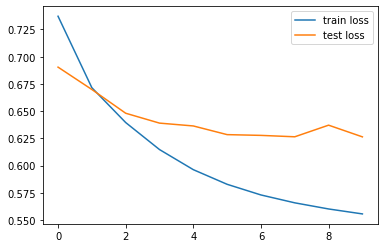

In [17]:
# Plot the train and test losses per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')    
plt.legend()
plt.show()

In [18]:
# Suppose I want to find recommendations for user 1
# First find the movies they have haven't seen
watched_movie_ids = df[df.new_user_id == 1].new_movie_id.values
watched_movie_ids

array([   2,   61,   69,  108,  239,  257,  263,  465,  476,  537,  583,
        874,  891,  907, 1098, 1171, 1184, 1188, 1221, 1231, 1242, 1298,
       1326, 1494, 1528, 1616, 1684, 1881, 1885, 1886, 1887, 1888, 1889,
       1890, 1902, 2206, 2369, 2370, 2705, 2772, 2862, 2865, 3063, 3072,
       3086, 3361, 3423, 3443, 3464, 3474, 3612, 3662, 3824, 3825, 3830,
       3833, 3834, 3835, 3837, 3843, 3865], dtype=int16)

In [19]:
potential_movie_ids = df[~df.new_movie_id.isin(watched_movie_ids)].new_movie_id.unique()

In [20]:
# How many movies can I recommend?
len(set(potential_movie_ids)) # set is used to remove duplicates

26683

In [21]:
# Repeat the user id many times
user_id_to_recommend = np.ones_like(potential_movie_ids)

In [22]:
# Convert to tensors
t_user_ids = torch.from_numpy(user_id_to_recommend).long().to(device)
t_movie_ids = torch.from_numpy(potential_movie_ids).long().to(device)

# Get predictions
with torch.no_grad():
    predictions = model(t_user_ids, t_movie_ids)

In [23]:
# Convert predictions to numpy 
predictions_np = predictions.cpu().numpy().flatten()

# Get sort index for predictions
sort_index = np.argsort(-predictions_np)

predictions_np, sort_index

(array([1.665025  , 0.70403934, 1.414407  , ..., 1.4358912 , 1.4241362 ,
        1.4345624 ], dtype=float32),
 array([  27,  183, 2674, ..., 6543, 2237, 8795]))

In [24]:
# Top 10 predictions
top_10_movie_ids = potential_movie_ids[sort_index[:10]]
top_10_scores = predictions_np[sort_index[:10]]

for movie, score in zip(top_10_movie_ids, top_10_scores):
    print("movie: ", movie, "score: ", score)

movie:  1175 score:  2.6202106
movie:  843 score:  2.609525
movie:  7206 score:  2.5800982
movie:  3437 score:  2.551416
movie:  18642 score:  2.5151055
movie:  1212 score:  2.4985247
movie:  10109 score:  2.497839
movie:  453 score:  2.4875908
movie:  8951 score:  2.4818149
movie:  1195 score:  2.4572964
